# Finloop PV segmentation

source (Huggingface): finloop/yolov8s-seg-solar-panels (aka Rzeszów model)

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

## libs

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [2]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import torch
from os import listdir
from os.path import isfile, join

In [3]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [4]:
pilot = 'pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg'
rzeszow_test = 'rzeszowSolar panels seg.v2i.yolov8-obb/test/images/*.jpg'
rzeszow_train = 'rzeszowSolar panels seg.v2i.yolov8-obb/train/images/*.jpg'
rzeszow_valid = 'rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/*.jpg'
synth_test = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/*.jpg'
synth_train = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/*.jpg'
synth_valid = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/*.jpg'

In [5]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"
data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [6]:
model_pt = "best.pt"

In [7]:
model = YOLO(model=model_pt, task="segment", verbose=True)

### segment analysis

In [8]:
def sum_pv_segments(pth, nazwa, model=model, disp_img=False, print_info=False):
    pv_area = 0
    image = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    image = torch.tensor(image, device=dev)
    img_w, img_h, _ = image.shape
    img_w_cp, img_h_cp = img_w, img_h 
    results = model(pth, save=print_info, name=nazwa, stream=True, imgsz=(img_w, img_h))
    # YOLO requires dims of 32 multiply
    if img_h % 32 != 0 or img_w % 32 != 0:
        disp_img = False
    if img_h % 32 != 0:
        img_h = img_h // 32 + 1
        img_h *= 32
    if img_w % 32 != 0:
        img_w = img_w // 32 + 1
        img_w *= 32
    for i, res in enumerate(results):
        if print_info:
            print(i)
        if res is not None and res.masks is not None:
            for j, msk in enumerate(res.masks):
                binary_mask = torch.where(msk.data > 0.5, 1, 0)
                pv_area += binary_mask.sum().div(img_w_cp*img_h_cp) # percentage
                if print_info:
                    print('\t', j, binary_mask)
                if disp_img:
                    binary_mask = binary_mask.data
                    bcg_white = torch.ones_like(image)*255
                    new_image = bcg_white * (1 - binary_mask[..., torch.newaxis]) + image * binary_mask[..., torch.newaxis]
                    plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                    plt.title(f"Mask {j} in {pth[pth.rfind('/'):]}")
                    plt.axis('off')
                    plt.show()
        if print_info:
            print(pv_area.item())
        if disp_img:
            plt.imshow(image.cpu())
            plt.title(f"base img {pth[pth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

In [9]:
def sum_pv_segments_batch(imgs, nazwa="no_info_run", model=model, disp_img=False, print_info=False, display_coef=100):
    pv_area = 0
    if isinstance(imgs, str):
        if "*" in imgs:
            imgs = imgs.split("*")[0]
            imgs = [join(imgs, f) for f in listdir(imgs) if isfile(join(imgs, f)) and f.endswith('jpg')]
            for i, img in enumerate(imgs):
                do_disp = i % display_coef == 0
                pv_area += sum_pv_segments(img, nazwa, model, disp_img and do_disp, print_info)
            return pv_area
        return sum_pv_segments(imgs, nazwa, model, disp_img, print_info)
    else:
        for img in imgs:
            pv_area += sum_pv_segments(img, nazwa, model, disp_img, print_info)
    return pv_area

## segment

### numbers

jeden obraz

In [10]:
sumka = sum_pv_segments_batch(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 191.8ms
Speed: 9.7ms preprocess, 191.8ms inference, 616.6ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.0971, device='cuda:0')

podwójnie

In [11]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 53.5ms
Speed: 6.1ms preprocess, 53.5ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 77.2ms
Speed: 4.7ms preprocess, 77.2ms inference, 11.6ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.1942, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 41.7ms


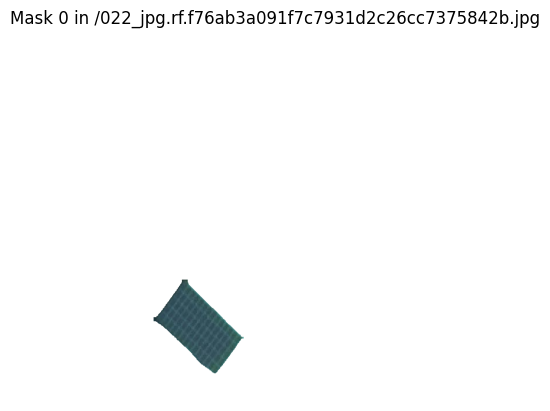

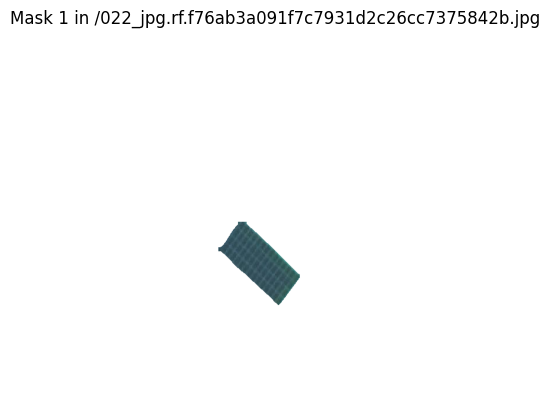

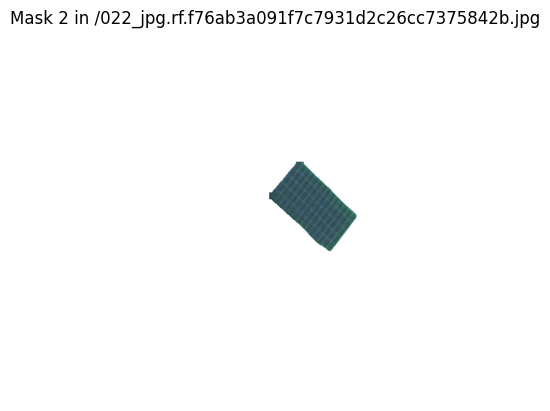

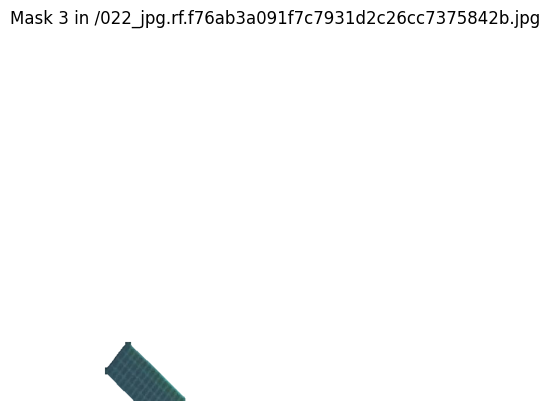

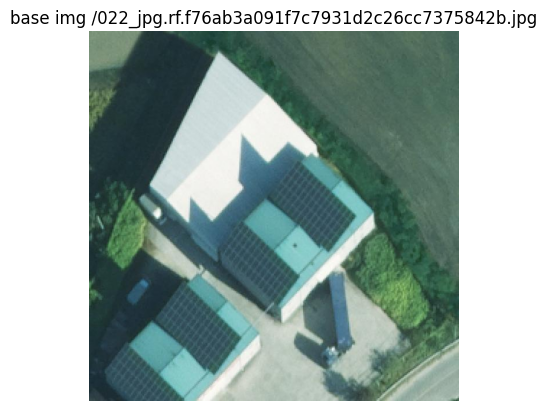

Speed: 2.4ms preprocess, 41.7ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.0971, device='cuda:0')

In [12]:
sum_pv_segments_batch(data_p, "proste_funk", disp_img=True)


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 61.0ms


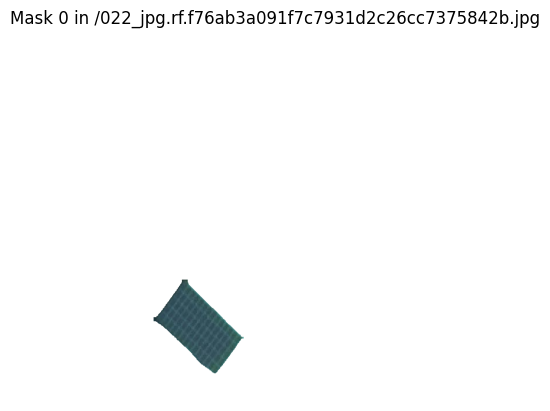

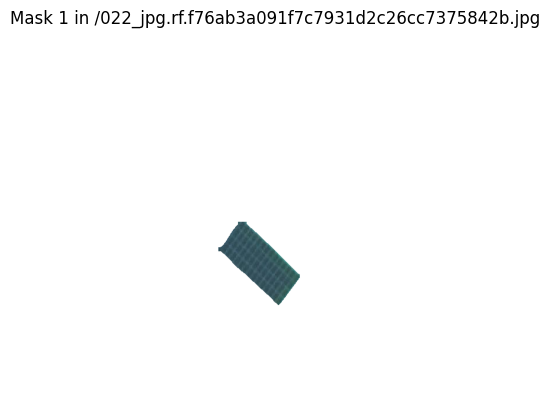

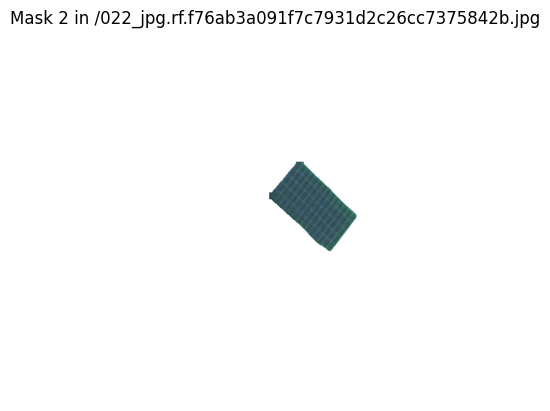

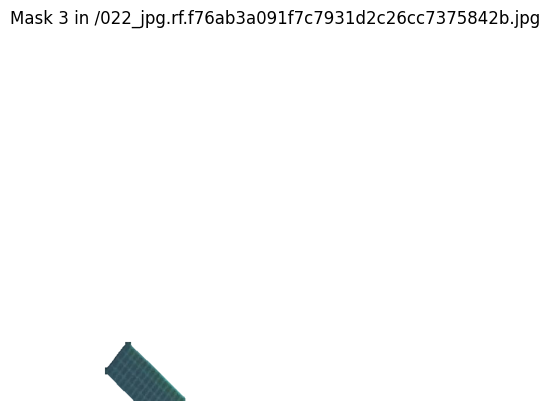

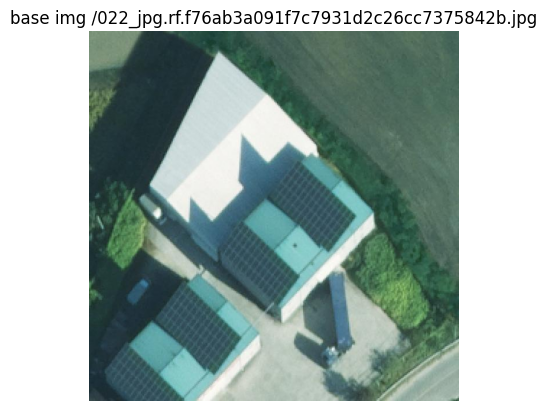

Speed: 13.4ms preprocess, 61.0ms inference, 23.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 48.8ms


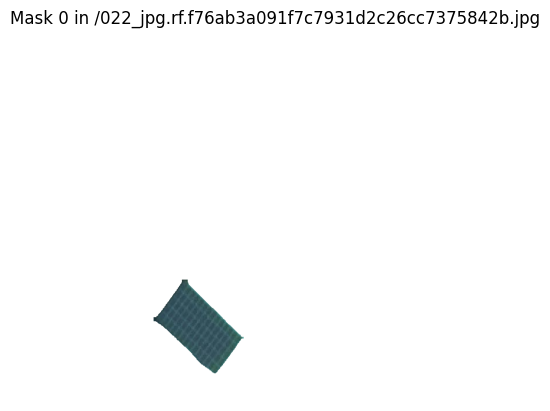

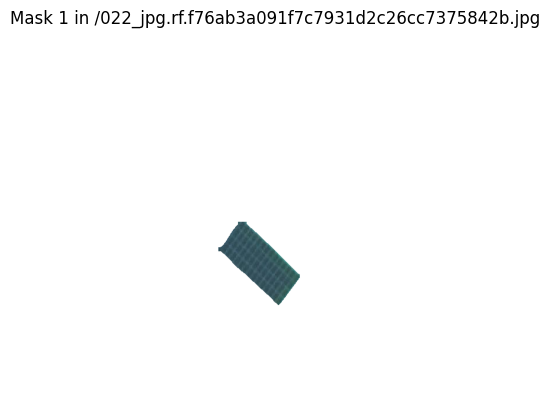

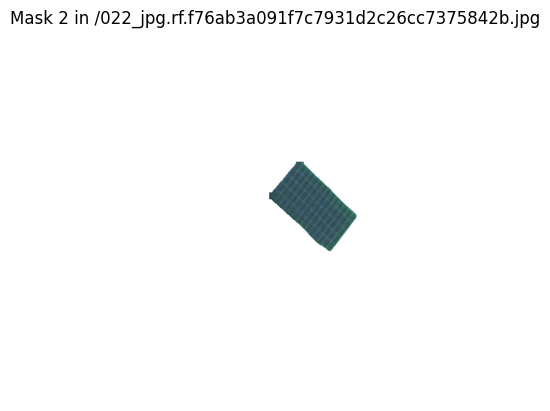

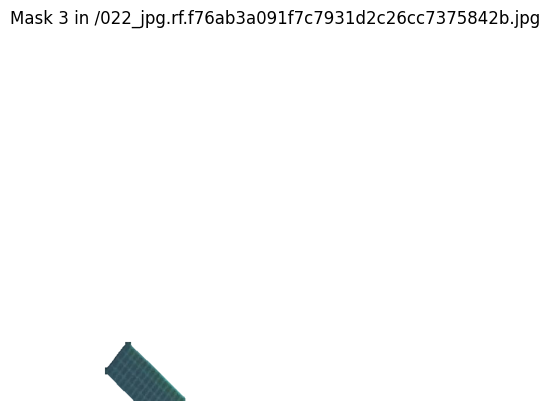

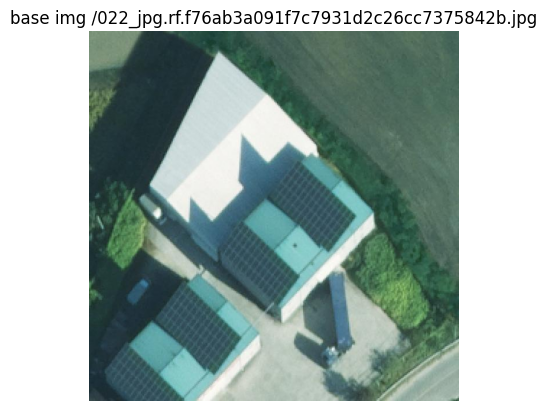

Speed: 2.4ms preprocess, 48.8ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.1942, device='cuda:0')

In [13]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 640x640 5 solar-panels, 158.7ms


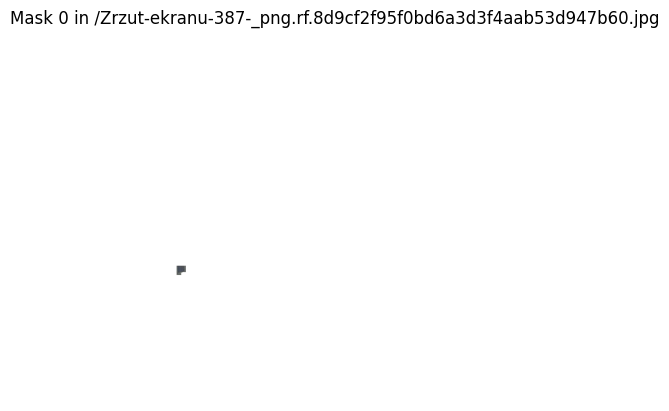

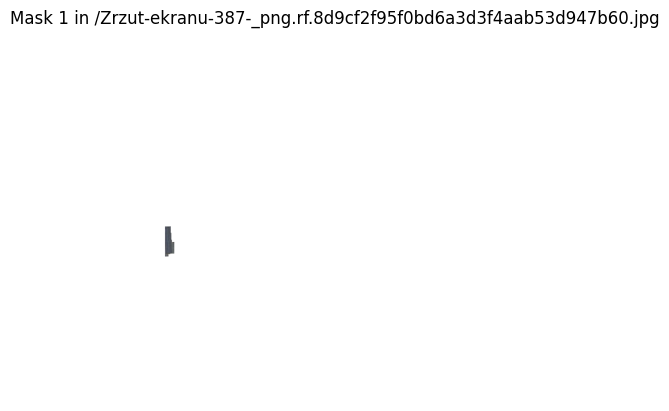

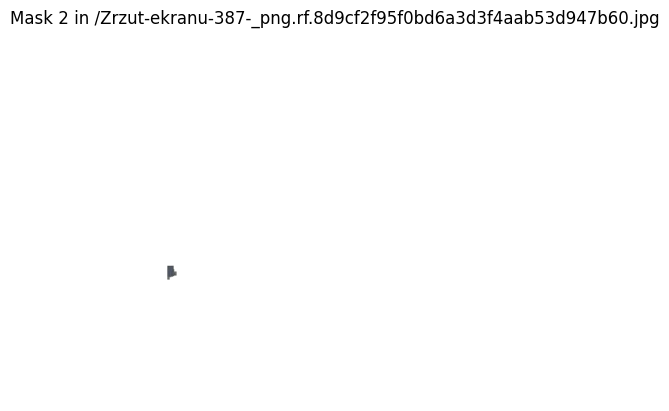

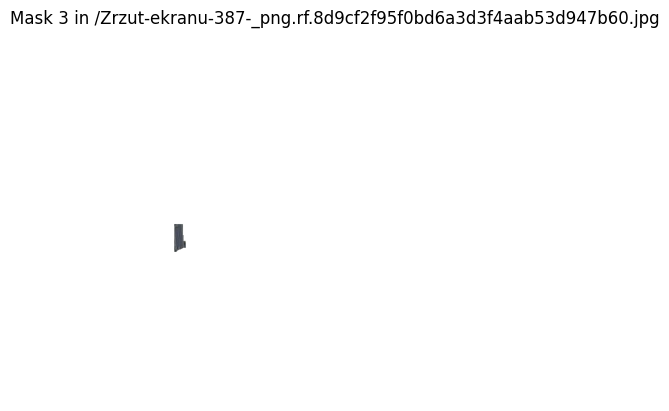

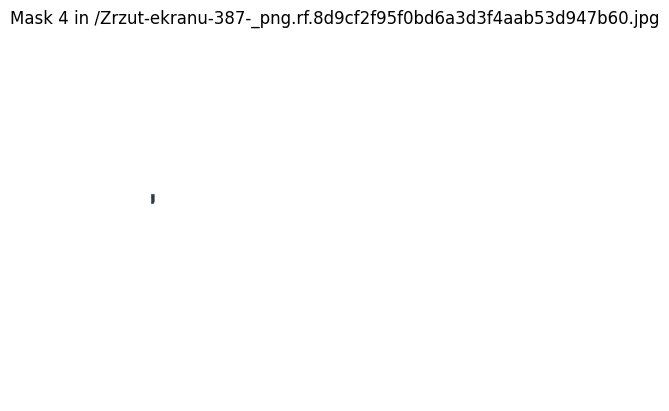

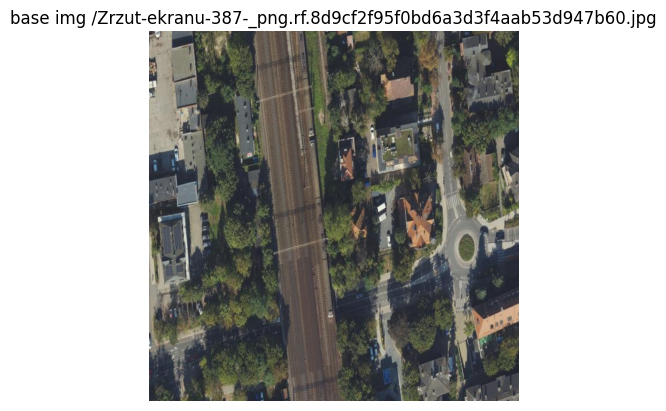

Speed: 5.1ms preprocess, 158.7ms inference, 42.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-391-_png.rf.389014ff4ad431e6038114a377054b0a.jpg: 640x640 2 solar-panels, 148.4ms
Speed: 6.5ms preprocess, 148.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-313-_png.rf.8195514f57fe4ab855a7ebb3e4f57ce0.jpg: 640x640 16 solar-panels, 129.5ms
Speed: 6.8ms preprocess, 129.5ms inference, 14.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-381-_png.rf.30e1db7981eb42605ec077c393dded26.jpg: 640x640 15 solar-panels, 49.5ms
Speed: 4.3ms preprocess, 49.5ms inference, 12.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelli

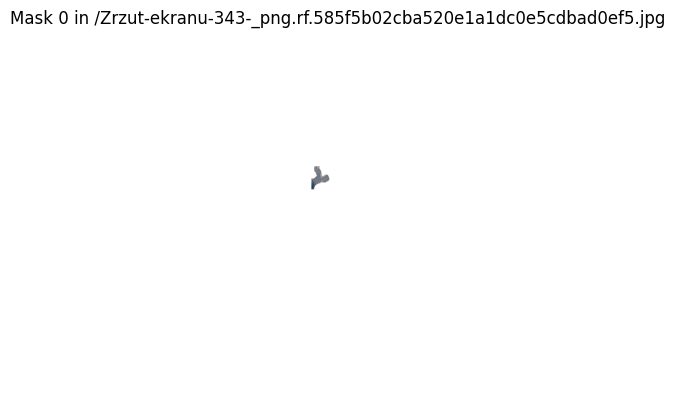

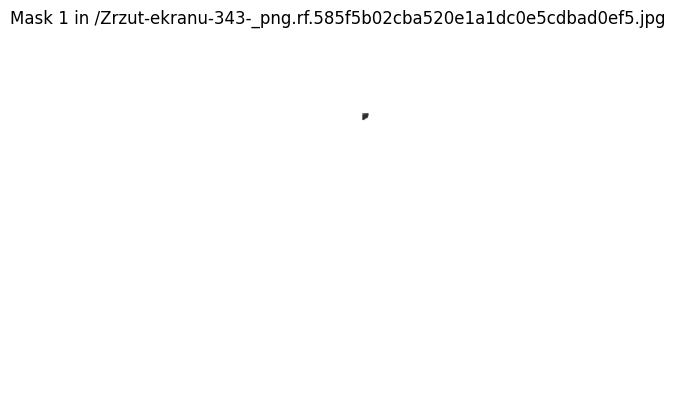

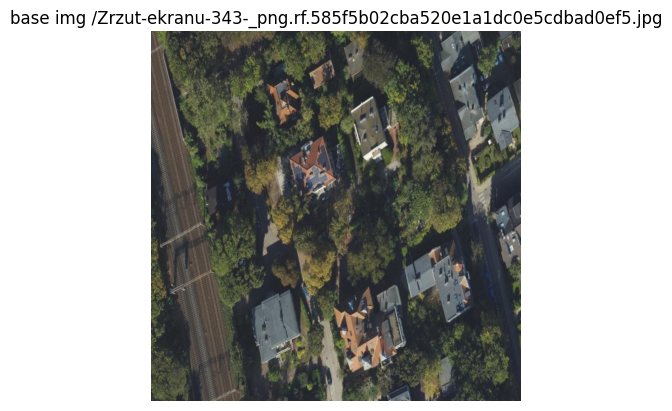

Speed: 1.9ms preprocess, 46.7ms inference, 14.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-321-_png.rf.b2e9da026493829652fbb766c2f1efda.jpg: 640x640 9 solar-panels, 36.0ms
Speed: 3.7ms preprocess, 36.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-346-_png.rf.629d6f3c11d8316d45b1b092f00d575d.jpg: 640x640 7 solar-panels, 22.8ms
Speed: 3.4ms preprocess, 22.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-384-_png.rf.4c85ba45bc2471e523545737b67fefd8.jpg: 640x640 1 solar-panel, 39.2ms
Speed: 3.6ms preprocess, 39.2ms inference, 15.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV

tensor(0.3503, device='cuda:0')

In [14]:
sum_pv_segments_batch(pilot, "pilot_segment", disp_img=True, display_coef=33)

## synthetic

### train


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-151946_png.rf.4ed7badabd10b6046232ecf5a4383384.jpg: 640x640 2 solar-panels, 26.7ms


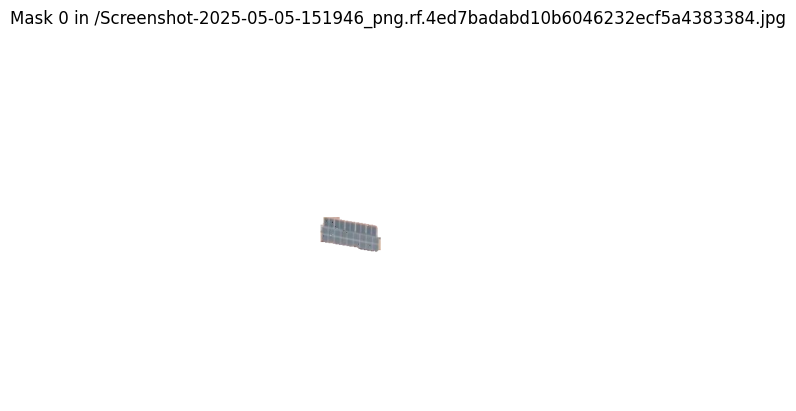

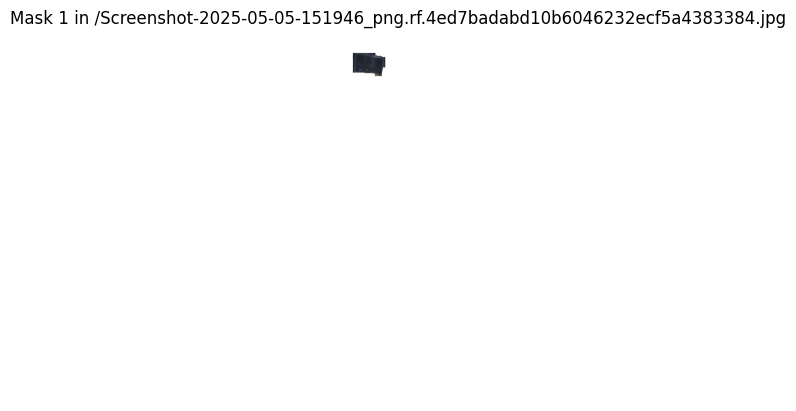

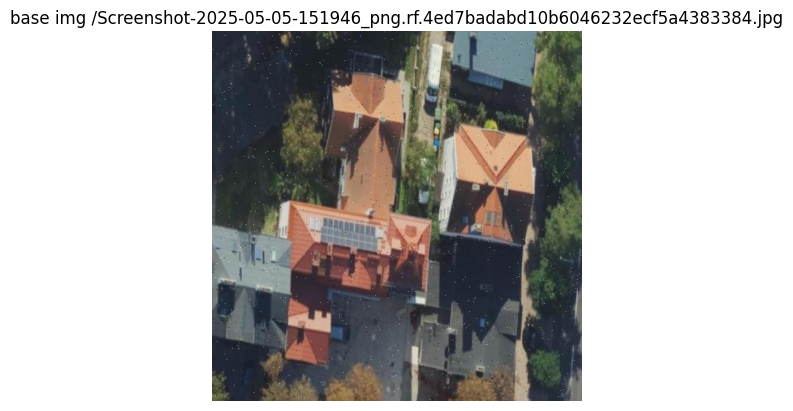

Speed: 3.9ms preprocess, 26.7ms inference, 13.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-165405_png.rf.2afd2d10ab2afd45ff2c0e8c3be5b915.jpg: 640x640 2 solar-panels, 39.8ms
Speed: 2.1ms preprocess, 39.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-165523_png.rf.12f36c05993b993f048a08a21007c98c.jpg: 640x640 7 solar-panels, 32.7ms
Speed: 3.7ms preprocess, 32.7ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r09_c04_jpg.rf.c0a65584b9ca900a4c1b0e7771b453b3.jpg: 640x640 10 solar-panels, 23.8ms
Speed: 2.4ms preprocess, 23.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1

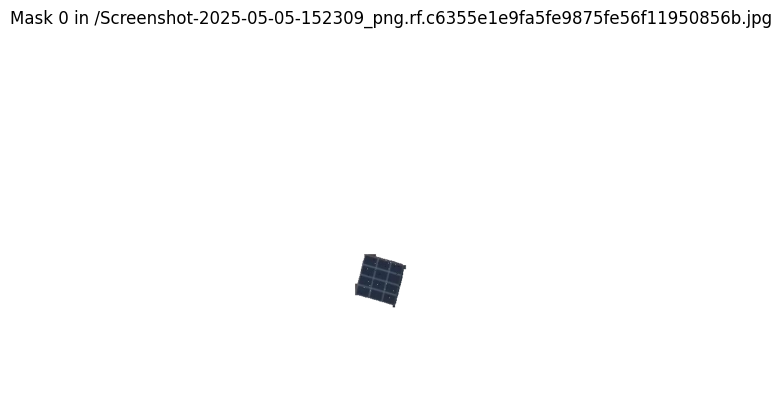

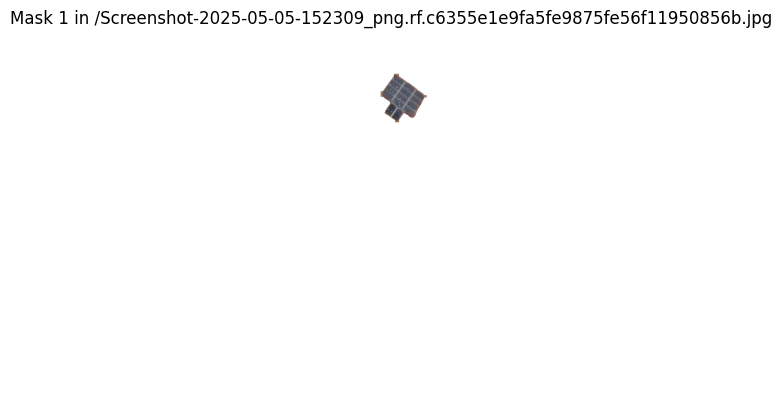

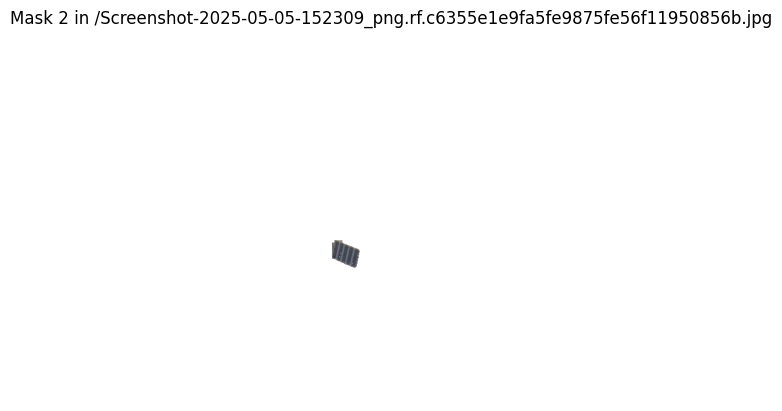

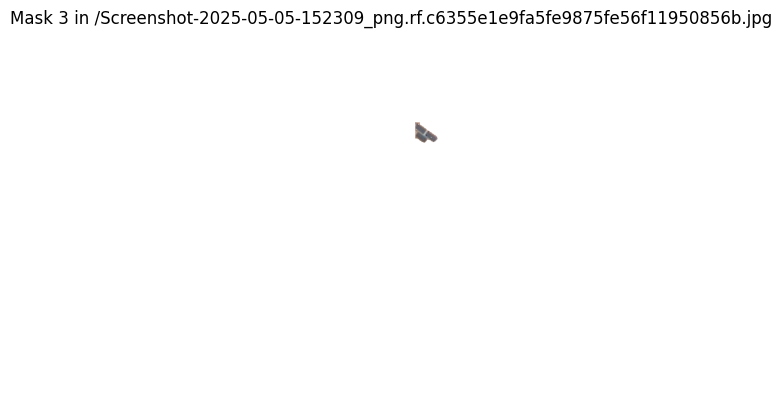

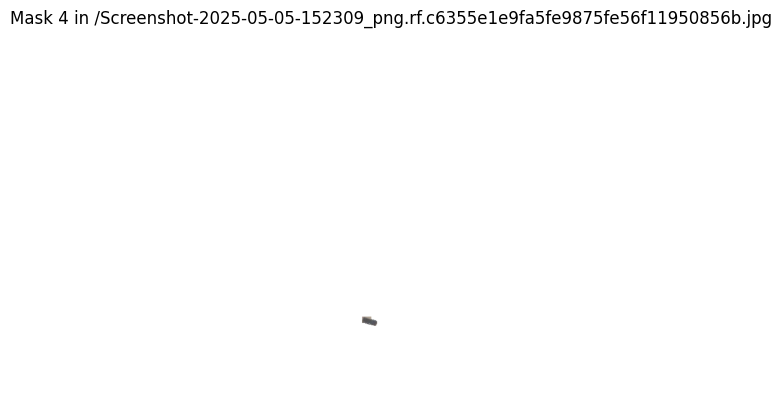

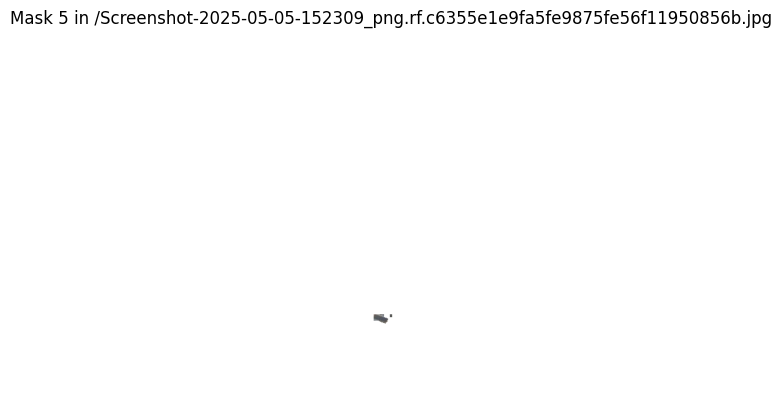

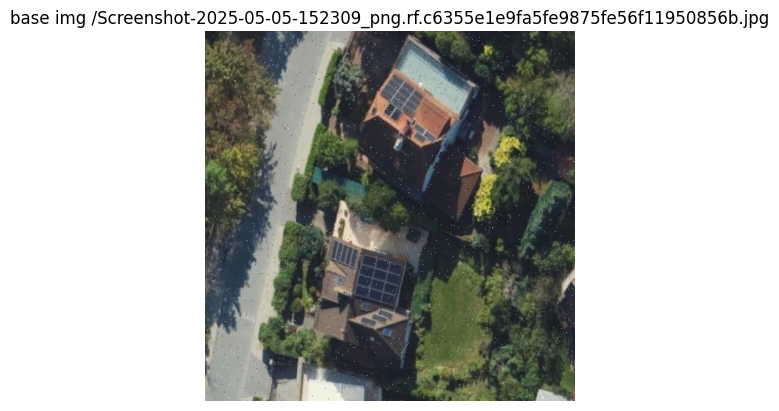

Speed: 2.1ms preprocess, 29.0ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r01_c02_jpg.rf.7d686c5137736c0427d2ea95bebb75df.jpg: 640x640 14 solar-panels, 24.0ms
Speed: 14.7ms preprocess, 24.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r01_c02_jpg.rf.77826a1d9af779e4ab73ebd3278af01b.jpg: 640x640 9 solar-panels, 30.9ms
Speed: 8.7ms preprocess, 30.9ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.fce413ee410f6a8aa17e7b99dccc1725.jpg: 640x640 1 solar-panel, 33.5ms
Speed: 1.9ms preprocess, 33.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/

tensor(3.3774, device='cuda:0')

In [15]:
sum_pv_segments_batch(synth_train, disp_img=True)

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142633_png.rf.ab6b4d1c58ab4c00e3ddbed5118af28b.jpg: 640x640 5 solar-panels, 48.2ms


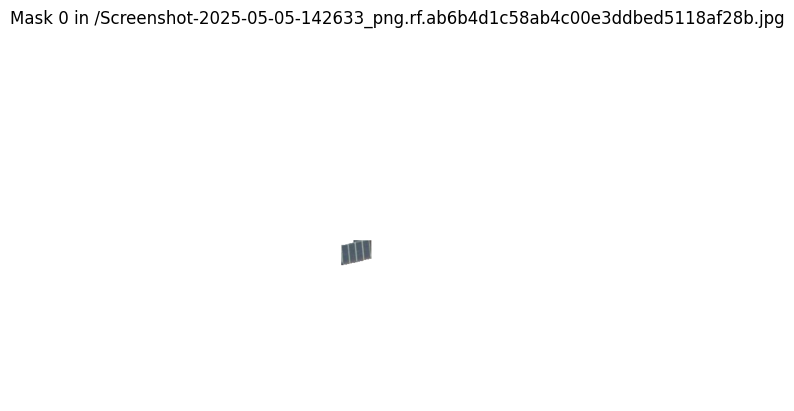

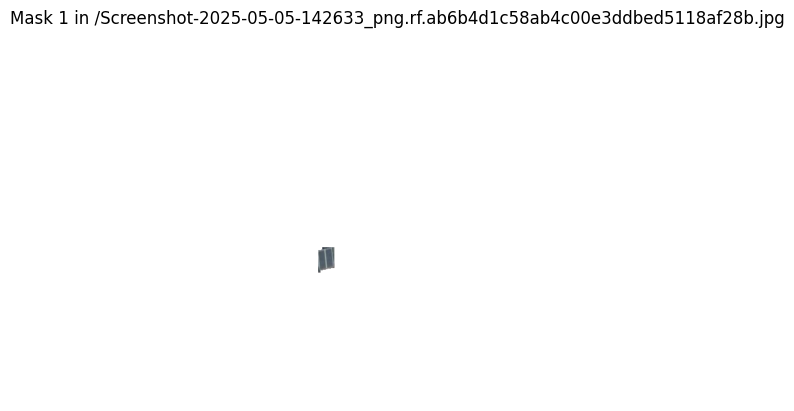

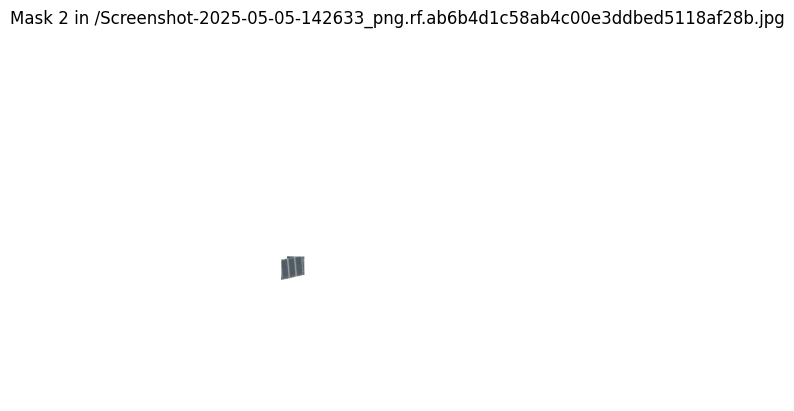

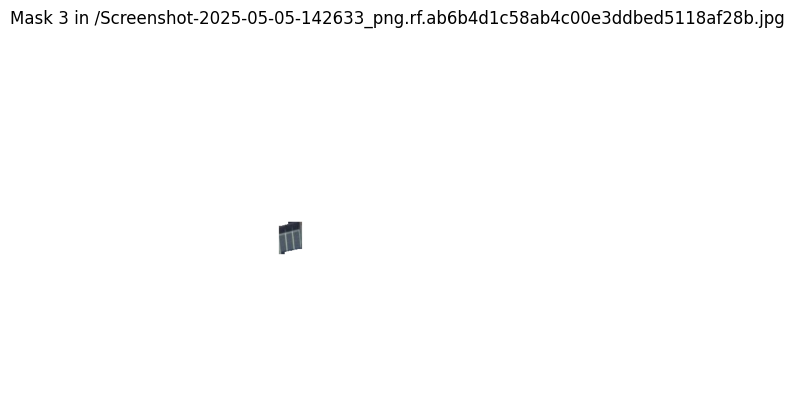

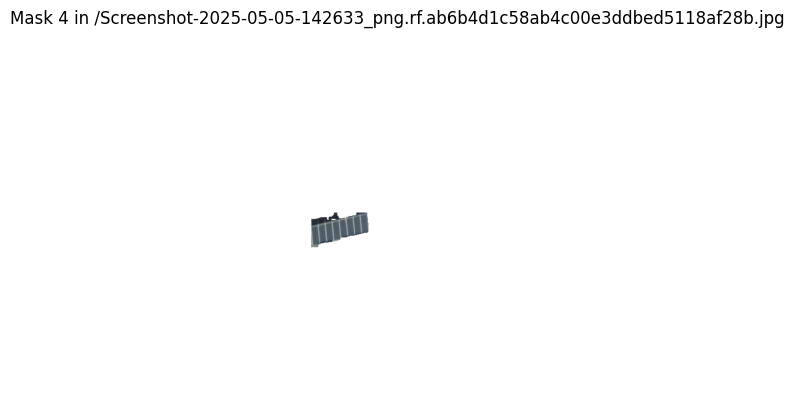

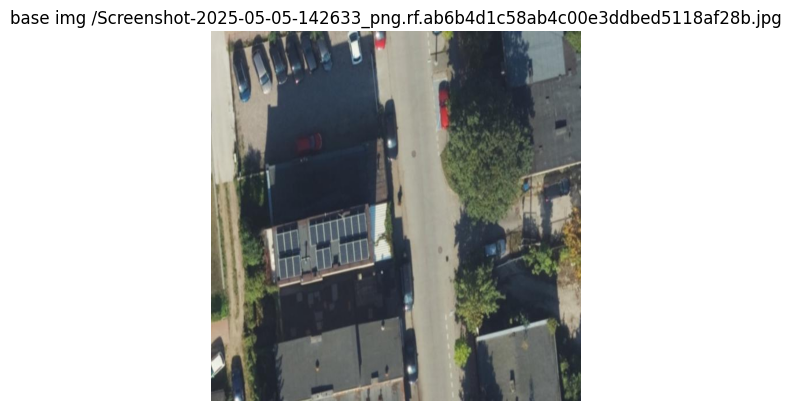

Speed: 6.6ms preprocess, 48.2ms inference, 19.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/tile_r06_c04_jpg.rf.8128d408e70b6fe564493d760116cff5.jpg: 640x640 7 solar-panels, 46.9ms
Speed: 5.6ms preprocess, 46.9ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142342_png.rf.d7373a2eee092999859ee3a20a9e7b13.jpg: 640x640 18 solar-panels, 41.2ms
Speed: 2.3ms preprocess, 41.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/tile_r05_c03_jpg.rf.c416104c3cad6ce9bddbddb0ae8af98a.jpg: 640x640 7 solar-panels, 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd

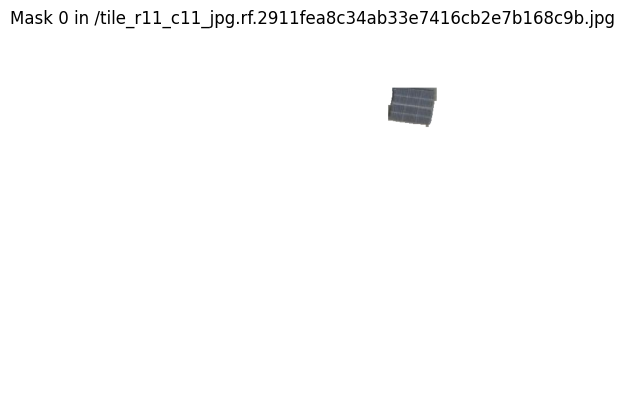

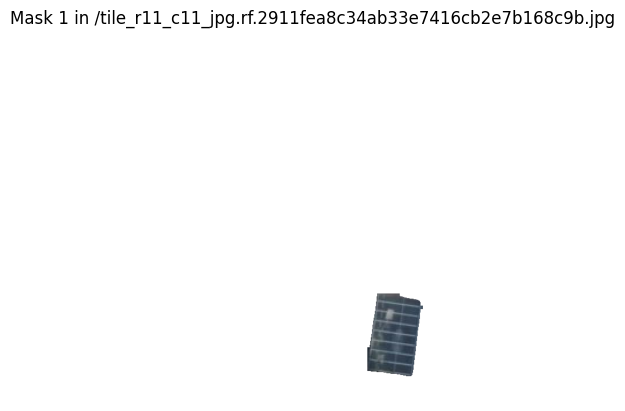

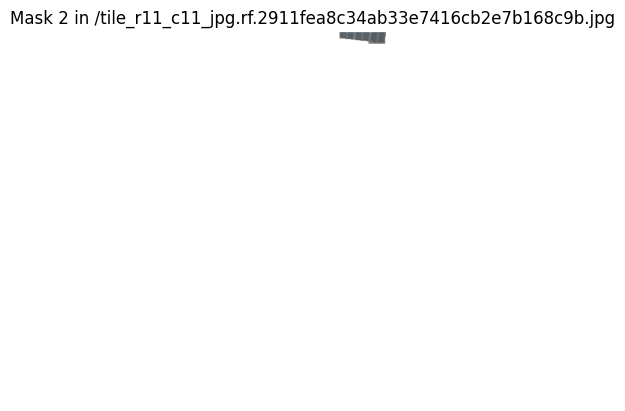

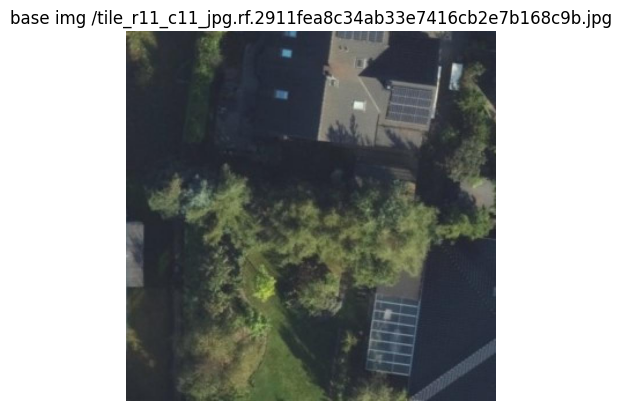

Speed: 3.3ms preprocess, 38.4ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142412_png.rf.7346005e071261338a10472ee5ae78b1.jpg: 640x640 6 solar-panels, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.3748, device='cuda:0')

In [16]:
sum_pv_segments_batch(synth_valid, disp_img=True, display_coef=10)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-165742_png.rf.39dad5274828e2fd6be55b93017dc12e.jpg: 640x640 1 solar-panel, 64.4ms


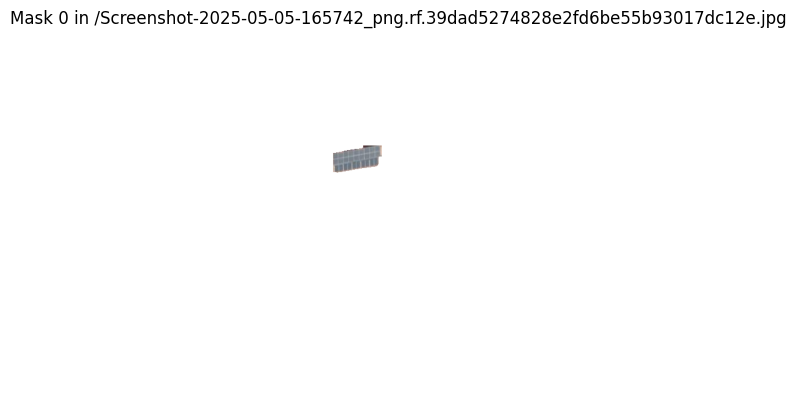

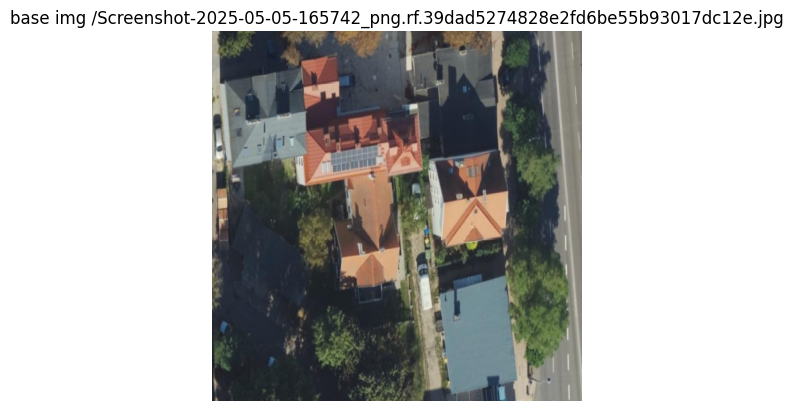

Speed: 8.0ms preprocess, 64.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152421_png.rf.f761f8709550a327d8cf6e833471d291.jpg: 640x640 5 solar-panels, 34.6ms
Speed: 4.5ms preprocess, 34.6ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143259_png.rf.5e77841caaec3af9f76d66e402dada53.jpg: 640x640 4 solar-panels, 44.5ms
Speed: 4.6ms preprocess, 44.5ms inference, 25.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152201_png.rf.b7b2d837d740644c873cfecb2a2a564f.jpg: 640x640 15 solar-panels, 63.4ms
Speed: 7.1ms preprocess, 63.4ms inference, 19.6ms postprocess per image at shape (1, 3, 640

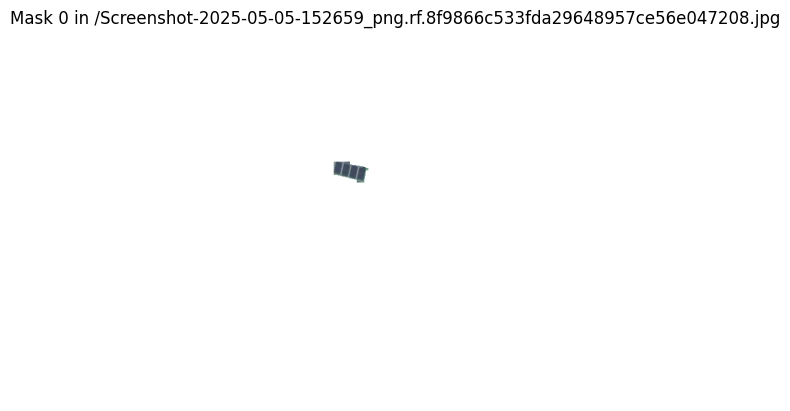

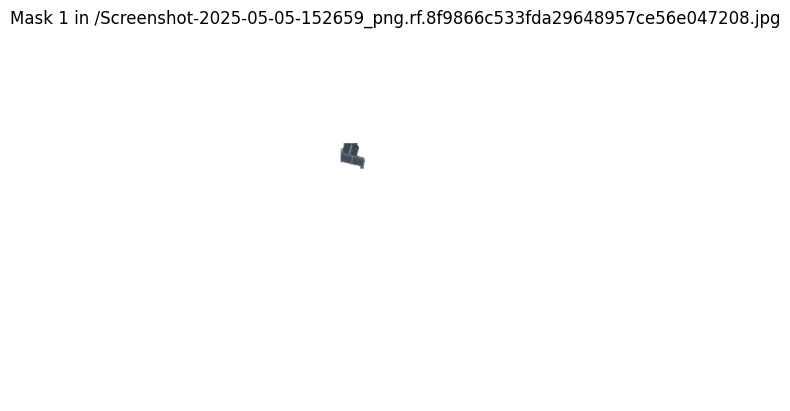

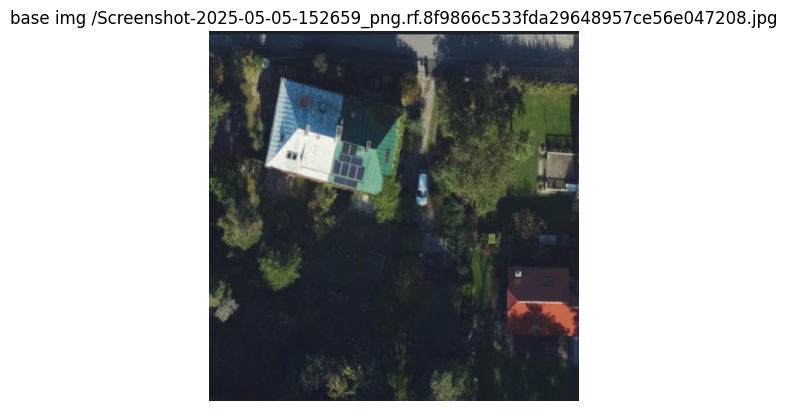

Speed: 6.2ms preprocess, 36.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-151813_png.rf.11adbb832968fd7ffe3ae94ff4b0f59d.jpg: 640x640 3 solar-panels, 44.2ms
Speed: 5.3ms preprocess, 44.2ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152708_png.rf.f41dbefc9cab846445803af9b77bf4f1.jpg: 640x640 3 solar-panels, 40.4ms
Speed: 4.7ms preprocess, 40.4ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143003_png.rf.fdf19d2ceff2192c26f9132617f7138b.jpg: 640x640 4 solar-panels, 40.8ms
Speed: 2.9ms preprocess, 40.8ms inference, 12.5ms postprocess per image at shape (1, 3, 640,

tensor(0.4084, device='cuda:0')

In [17]:
sum_pv_segments_batch(synth_test, disp_img=True, display_coef=10)

## Rzeszów

### train

too big to run

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task1258_jpg.rf.b137128531187339a879b284ebae9e4f.jpg: 512x512 1 solar-panel, 261.0ms


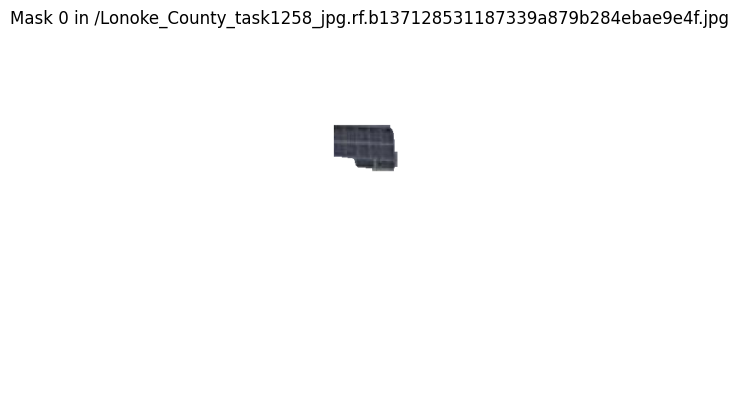

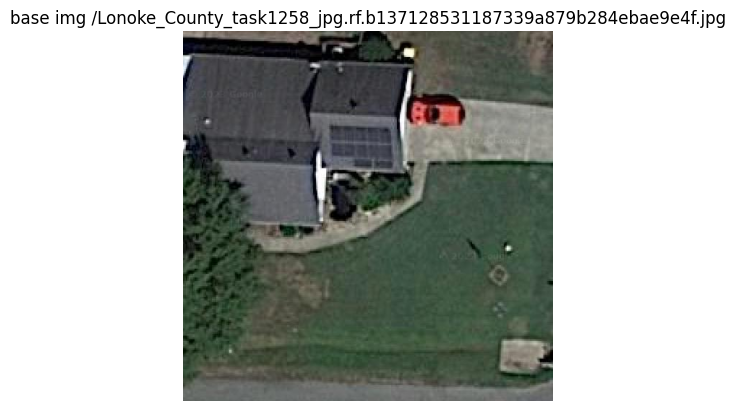

Speed: 2.6ms preprocess, 261.0ms inference, 17.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/PV08_322669_1197140_jpg.rf.e172b016bec73d5fa36a4a5fc28170e2.jpg: 256x256 1 solar-panel, 234.6ms
Speed: 3.6ms preprocess, 234.6ms inference, 5.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/41935-2019_Steyr_20_RGBI_png_jpg.rf.e62a4697a524b23eb1cb6ac810694e44.jpg: 320x320 6 solar-panels, 121.1ms
Speed: 1.4ms preprocess, 121.1ms inference, 7.9ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Boone_County_task12503_jpg.rf.baf04f8668684934d847ce2a29cb82ee.jpg: 256x256 4 solar-panels, 97.2ms
Speed: 0.9ms preprocess, 97.2ms inference, 26.4ms postprocess per image at shape (1, 3, 256, 256)

im

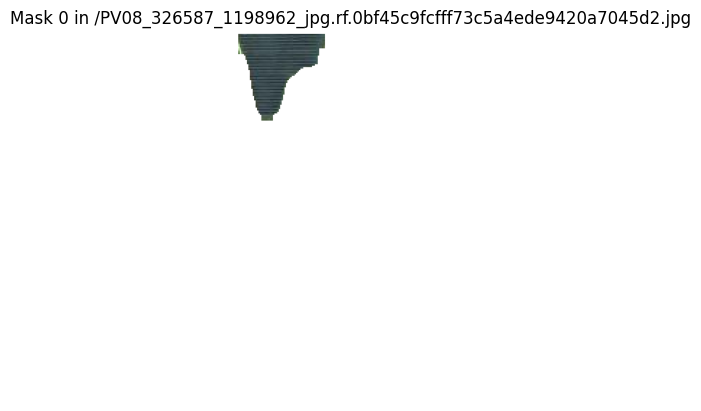

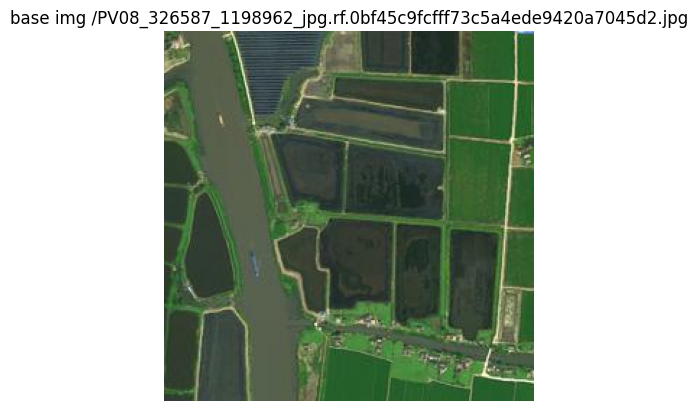

Speed: 0.8ms preprocess, 20.8ms inference, 4.4ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/PV03_343012_1173453_jpg.rf.e3d8eaf990dc2f54d84b4dc773c9eca0.jpg: 256x256 2 solar-panels, 41.1ms
Speed: 1.8ms preprocess, 41.1ms inference, 43.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Carroll_County_task7241_jpg.rf.5556b8a2dc60b6bad059517e132eea86.jpg: 512x256 1 solar-panel, 41.9ms
Speed: 4.2ms preprocess, 41.9ms inference, 7.6ms postprocess per image at shape (1, 3, 512, 256)

WARNING ⚠️ imgsz=[1132, 2048] must be multiple of max stride 32, updating to [1152, 2048]
image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-13-at-18-42-58_png_jpg.rf.9820915e1a1ed4f0a236cf06db5da1f0.jpg: 1152x2048 1 solar-panel, 166.0ms
Spe

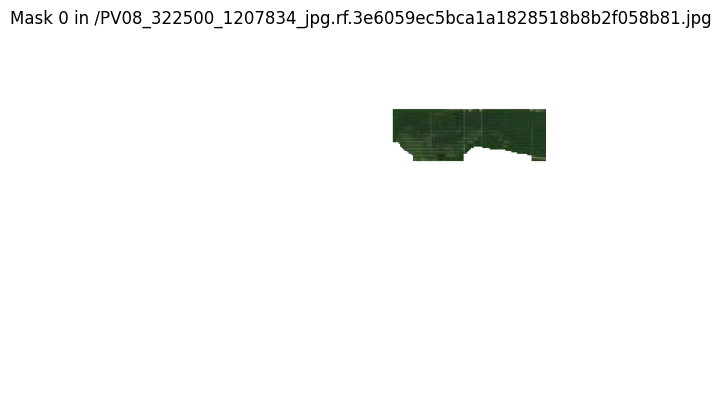

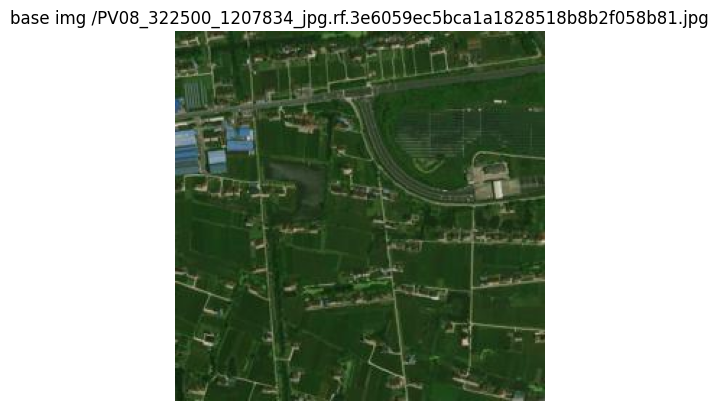

Speed: 1.0ms preprocess, 21.6ms inference, 5.9ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/1663318584_894892_jpg.rf.357327b0eb20e2cc3bd2a6906e99aed5.jpg: 416x416 7 solar-panels, 25.2ms
Speed: 1.1ms preprocess, 25.2ms inference, 6.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/PV08_328207_1196423_jpg.rf.761cc69f7fe31bf6c877b68dbb56e9a2.jpg: 256x256 5 solar-panels, 36.6ms
Speed: 2.2ms preprocess, 36.6ms inference, 9.8ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Crawford_County_task13688_jpg.rf.3c4327ebd4616c316c43c516aaeca8e0.jpg: 512x512 1 solar-panel, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 4.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/m

tensor(81.1287, device='cuda:0')

In [18]:
sum_pv_segments_batch(rzeszow_valid, disp_img=True, display_coef=333)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/092_jpg.rf.f87365dca65825ad79be800a2a07b4ea.jpg: 640x640 4 solar-panels, 45.7ms


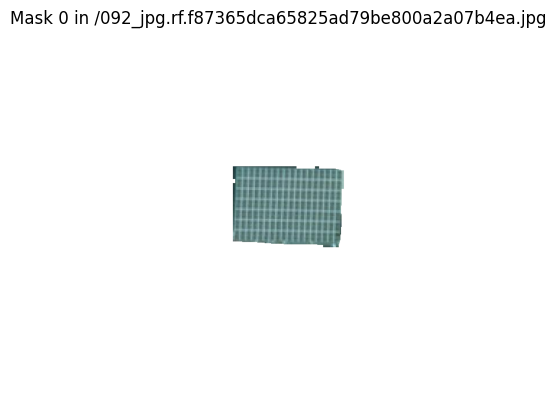

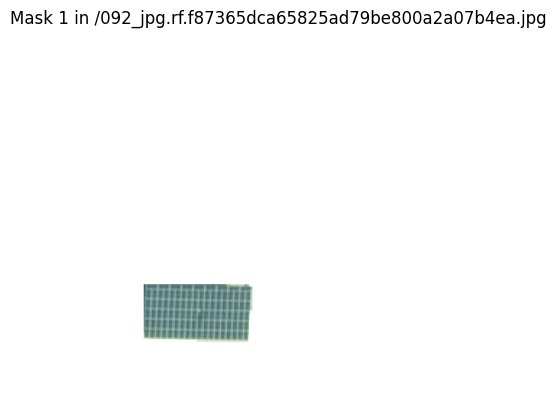

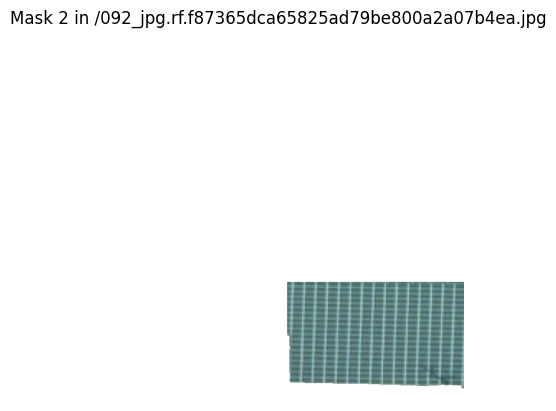

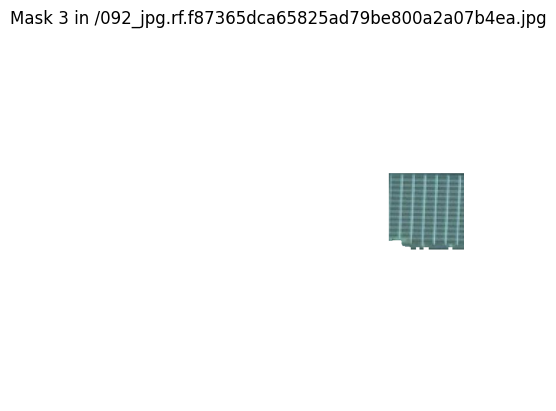

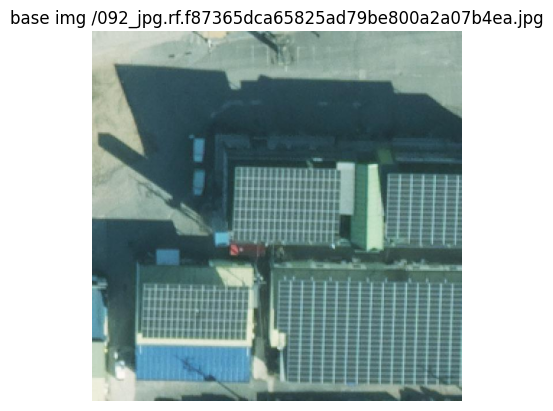

Speed: 4.9ms preprocess, 45.7ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

WARNING ⚠️ imgsz=[608, 725] must be multiple of max stride 32, updating to [608, 736]
image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/2023-07-09_22-18_1_png.rf.fca22797f8f9d6d9e6c5965115d6f416.jpg: 608x736 9 solar-panels, 36.3ms
Speed: 3.5ms preprocess, 36.3ms inference, 7.1ms postprocess per image at shape (1, 3, 608, 736)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/Crawford_County_task10496_jpg.rf.5baf2347a7bac61486a4bb1c9bd9dbff.jpg: 512x512 1 solar-panel, 23.4ms
Speed: 1.8ms preprocess, 23.4ms inference, 6.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV08_322374_1197402_jpg.rf.8f98d3965ceabbed5f34941a6a10bbfb.jpg: 256x256 10 solar-panels, 27.2ms
Speed: 0.9ms preprocess, 27.2m

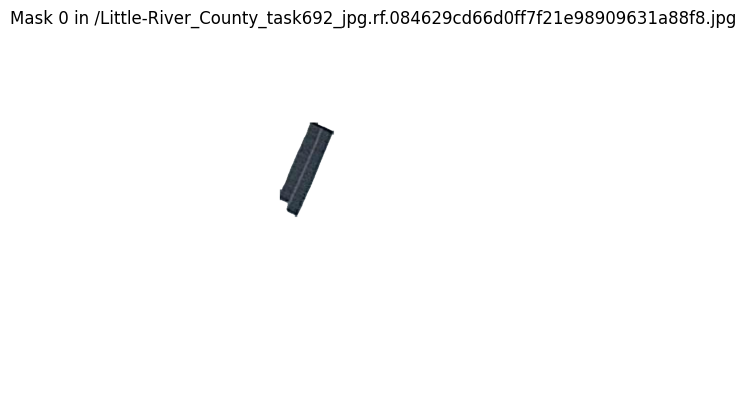

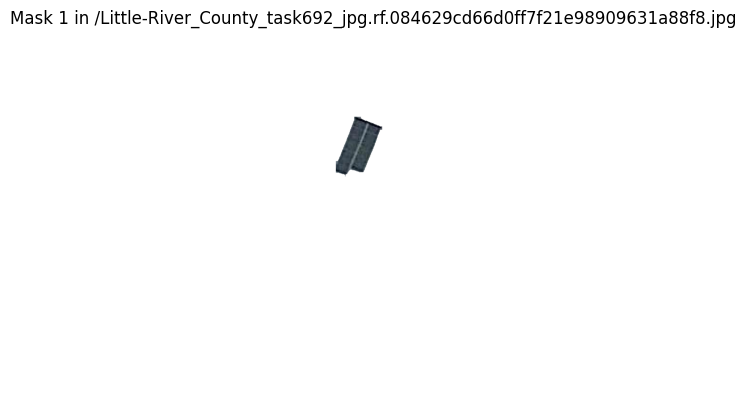

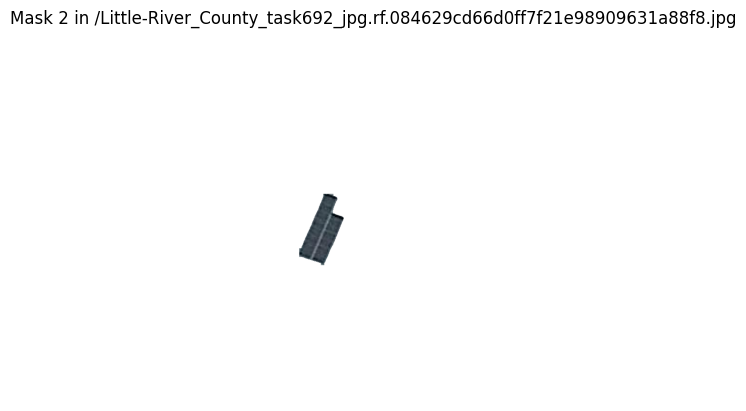

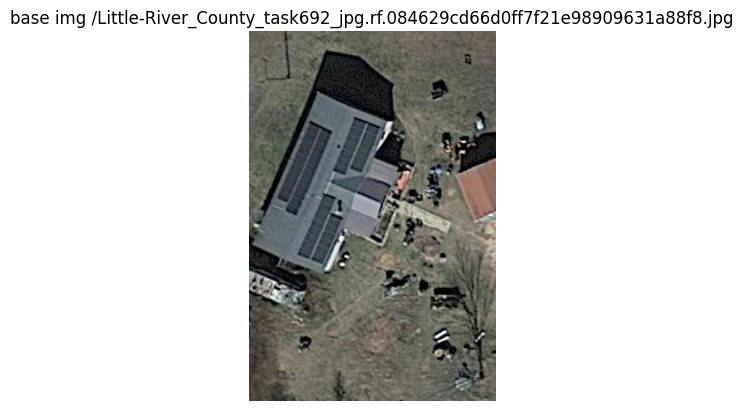

Speed: 5.3ms preprocess, 30.8ms inference, 13.7ms postprocess per image at shape (1, 3, 768, 512)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV08_342289_1184006_jpg.rf.99f69d10b9fa4dd026b2871266ce7396.jpg: 256x256 4 solar-panels, 21.0ms
Speed: 1.2ms preprocess, 21.0ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/Washington_County_task16584_jpg.rf.f889ebf0f664185829a78b437956cac6.jpg: 512x256 1 solar-panel, 16.2ms
Speed: 0.9ms preprocess, 16.2ms inference, 6.2ms postprocess per image at shape (1, 3, 512, 256)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV08_344239_1199475_jpg.rf.3600c88a350394a15017223d1ababb10.jpg: 256x256 (no detections), 22.7ms
Speed: 1.1ms preprocess, 22.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /hom

tensor(48.0740, device='cuda:0')

In [19]:
sum_pv_segments_batch(rzeszow_test, disp_img=True, display_coef=333)